In [1033]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# LABEL CORRECTING

In [1034]:
def FIFO_label_correcting(graph, source, sink):
    labels = {node : float('inf') for node in graph.nodes()}
    labels[source] = 0
    predecessors = {}
    predecessors[source] = 0
    q = [source]

    while q:
        u = q.pop(0)
        for v in graph.successors(u):
            if labels[v] > labels[u] + graph[u][v]['cost']:
                labels[v] = labels[u] + graph[u][v]['cost']
                predecessors[v] = u
                if v not in q:
                    q.append(v)


    u = sink
    links = []
    if sink not in predecessors: return labels, links

    while u != source:
        links.append((predecessors[u],u))
        u = predecessors[u]
    links.reverse()
    return labels, links

In [1035]:
def TDLC(graph, sink, M, step):
  labels = {node : [float('inf') for _ in range(0,(M+1)*step,step)] for node in graph.nodes}
  labels[sink] = [0 for _ in range(0,(M+1)*step,step)]
  SElist = [sink]
  paths = {node : {t : [] for t in range(0,(M+1)*step,step)} for node in graph.nodes}
  paths[sink] = {t : [sink] for t in range(0,(M+1)*step,step)}

  while SElist:
      v = SElist.pop(0)
      for u in graph.predecessors(v):
        changed = False
        for t in range(0,(M+1)*step,step):
            if t + graph[u][v]['cost'][t] > M:
                newlabel = float('inf')  
            else:
                newlabel = graph[u][v]['cost'][t] + labels[v][int(t + graph[u][v]['cost'][t])]
            if labels[u][t] > newlabel:
                labels[u][t] = newlabel
                changed = True
                paths[u][t] = [u] + paths[v][int(t + graph[u][v]['cost'][t])]
                
        if changed:
            SElist.append(u)

  return labels, paths

# MIN COST FLOW SUCCESSIVE SHORTEST PATH

In [1036]:
def mcf_ssp(graph, source, sink, target_flow):
    while True:
        if sum([graph[source][v]['flow'] for v in graph.successors(source)]) == target_flow:
            break

        residual_graph = nx.DiGraph()
        for u, v, data in graph.edges(data=True):
            residual_capacity = data['capacity'] - data['flow']
            if residual_capacity > 0:
                residual_graph.add_edge(u, v, capacity=residual_capacity, cost=data['cost'])

        _, shortest_path = FIFO_label_correcting(residual_graph, source, sink)

        # If there is no minimum cost path, terminate the algorithm.
        if len(shortest_path) == 0:
            break
 
        max_augmentable_flow = min([residual_graph[u][v]['capacity'] for u, v in shortest_path])

        # Augment the flow along the shortest path.
        for u, v in shortest_path:
            graph[u][v]['flow'] += max_augmentable_flow

# SIMULATION

In [1037]:
def td_mcf_ssp(graph, source, sink, M, step, target_flow):
    start = 0
    sum_flow = 0
    while True:
        if sum_flow >= target_flow: break
        if start > M: 
            print(f'imposible to go from {source}')
            return
        residual_graph = nx.DiGraph()
        residual_capacity = {(u,v) : np.zeros(M+1).tolist() for u, v in graph.edges()}
        residual_cost = {(u,v): [float('inf')] * (M+1) for u, v in graph.edges()}

        for t in range(0,(M+1)*step,step):
          for u, v, data in graph.edges(data = True):
              residual_capacity[u,v][t] = data['capacity'][t] - data['flow'][t]
              if residual_capacity[u,v][t] > 0:
                  residual_graph.add_edge(u, v)
                  residual_cost[u,v][t] = data['cost'][t]
        nx.set_edge_attributes(residual_graph, residual_cost, 'cost')

        __dict__, paths = TDLC(residual_graph, sink, M, step)
        shortest_path = paths[source][start]
        # If there is no minimum cost path, terminate the algorithm.
        if len(shortest_path) == 0:
            start += 1
            continue

        # Calculate the maximum flow that can be augmented along the shortest path.
        links = [(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path)-1)]
        t = start
        capacities = []
        for u,v in links:
            capacities.append(graph[u][v]['capacity'][t])
            t += graph[u][v]['cost'][t]
        max_augmentable_flow = min(capacities)
        sum_flow += max_augmentable_flow

        # Augment the flow along the shortest path.
        t = start
        for u, v in links:
            graph[u][v]['flow'][t] += max_augmentable_flow
            t += graph[u][v]['cost'][t]
    

In [1038]:
G = nx.DiGraph()
G.add_edge('s','1')
G.add_edge('1','2')
G.add_edge('1','3')
G.add_edge('2','3')
G.add_edge('2','4')
G.add_edge('3','4')
G.add_edge('3','5')
G.add_edge('4','t')
G.add_edge('5','t')

M = 10
arc_flow = {(u,v): np.zeros(M+1) for u,v,data in G.edges(data = True)}

arc_capacity = {(u,v): np.random.randint(1,7,M+1).tolist() for u,v,data in G.edges(data = True)}
arc_capacity['s','1'] = (np.ones(M+1)*5).tolist()
arc_capacity['4','t'] = (np.ones(M+1)*3).tolist()
arc_capacity['5','t'] = (np.ones(M+1)*2).tolist()

arc_cost = {(u,v): np.random.randint(1,4,M+1).tolist() for u,v,data in G.edges(data = True)}
arc_cost['4','t'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost['5','t'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost['s','1'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost

nx.set_edge_attributes(G, arc_flow, 'flow')
nx.set_edge_attributes(G, arc_capacity, 'capacity')
nx.set_edge_attributes(G, arc_cost, 'cost')
td_mcf_ssp(G, 's', 't', M, 1, 5)

{('s', '1'): 5, ('1', '2'): 2, ('1', '3'): 3, ('2', '3'): 2, ('2', '4'): 0, ('3', '4'): 3, ('3', '5'): 2, ('4', 't'): 3, ('5', 't'): 2}


{('s', '1'): Text(0.5, 0.0, '5/5, 0'),
 ('1', '2'): Text(1.5, 0.25, '2/4, 3'),
 ('1', '3'): Text(1.5, -0.25, '3/3, 2'),
 ('2', '3'): Text(2.0, 0.0, '2/4, 2'),
 ('2', '4'): Text(2.5, 0.5, '0/6, 2'),
 ('3', '4'): Text(2.5, 0.0, '3/3, 1'),
 ('3', '5'): Text(2.5, -0.5, '2/3, 3'),
 ('4', 't'): Text(3.5, 0.25, '3/3, 0'),
 ('5', 't'): Text(3.5, -0.25, '2/2, 0')}

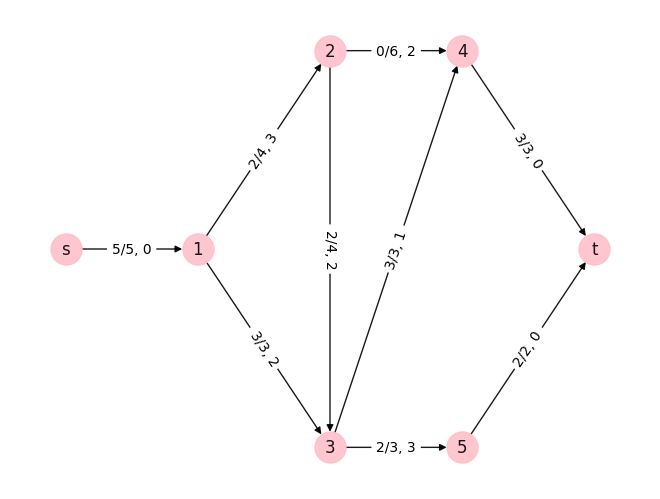

In [1039]:
np.random.seed(15)
arc_capacities = {(u,v): np.random.randint(3,7) for u, v in G.edges()}
arc_capacities['s','1'] = 5
arc_capacities['4','t'] = 3
arc_capacities['5','t'] = 2
arc_costs = {(u,v): np.random.randint(1,4) for u,v in G.edges()}
arc_costs['s','1'], arc_costs['4', 't'], arc_costs['5','t'] = 0,0,0
arc_flow = {(u,v): 0 for u, v in G.edges}
nx.set_edge_attributes(G, arc_capacities, 'capacity')
nx.set_edge_attributes(G, arc_costs, 'cost')
nx.set_edge_attributes(G, arc_flow, 'flow' )
mcf_ssp(G, 's', 't', 5)
print({(u, v): data['flow'] for u,v,data in G.edges(data = True)})
pos = {
    's' : (0,0) ,
    '1' : (1,0) ,
    '2' : (2,0.5), 
    '3' : (2,-0.5),
    '4' : (3,0.5),
    '5' : (3,-0.5),
    't' : (4,0)
}
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(G, pos,  edge_labels={(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in G.edges(data = True)})


''

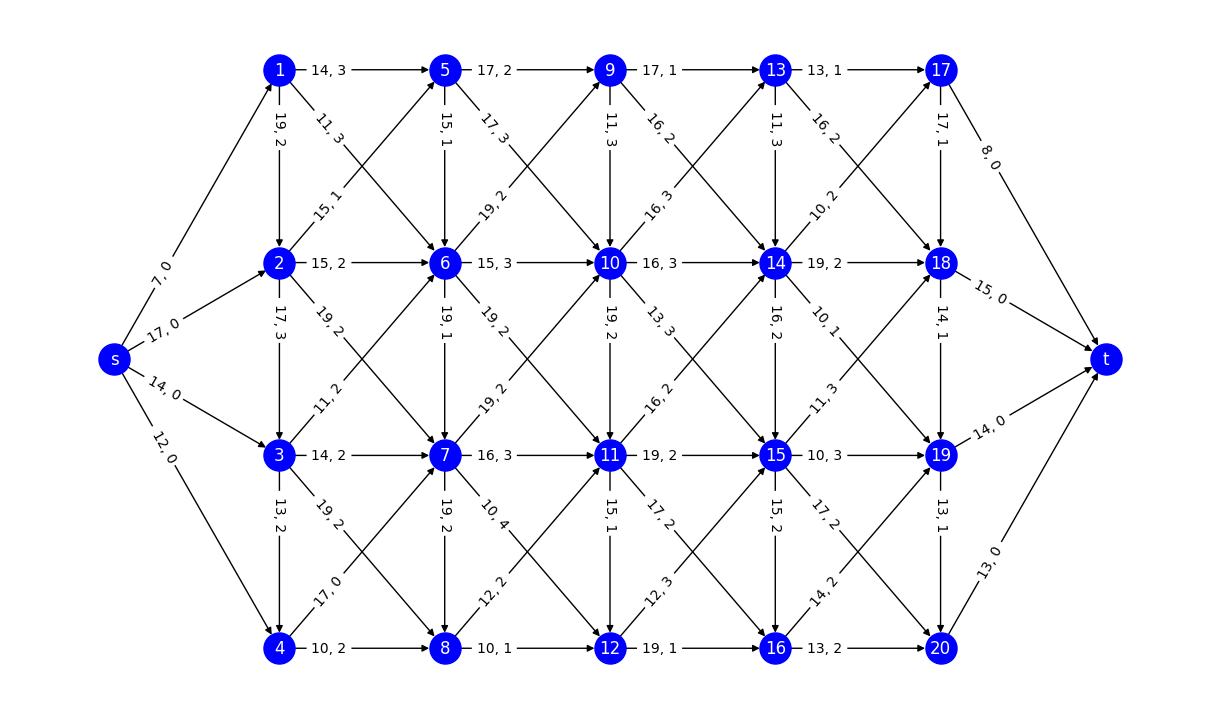

In [1040]:
network = nx.DiGraph()
for i in range(1,21):
    network.add_node(i)
for i in range(1,21,4):
    for j in range(i,i+4):
        if not i == 17: network.add_edge(j,j+4)
        if not j % 4 == 0:
            network.add_edge(j,j+1)
            if not i == 17: network.add_edge(j,j+5)
        if not j % 4 == 1 and not i == 17:
            network.add_edge(j,j+3)
for i in range(1,5):
    network.add_edge('s',i)
for i in range(17,21):
    network.add_edge(i, 't')
pos = {}
t = 0
for i in range(1,21,4):
    for j in range(i,i+4):
        pos[j] = (t,-j % 4)
    t += 1
pos['s'] = (-1,1.5)
pos['t'] = (5,1.5)

M = 10
num_car = 50
np.random.seed(15)

p = 5
T = 2
S = 3
lagrange_multiplier = [{(u,v): (np.random.random(size = T)).tolist() for u,v in network.edges()} for i in range(0,S)]
sum_lagrange = [{ (u,v) : sum(lagrange_multiplier[i][u,v]) for u, v in network.edges()} for i in range(0,S)]
sum_alphas = {(u,v) : sum([sum_lagrange[i][u,v] for i in range(0,S)]) for u,v in network.edges()}

travel_time = {(u,v) : round(p - sum_alphas[u,v]) for u,v in network.edges()}
#travel_time = {(u,v): np.random.randint(2,5) for u, v in network.edges()}
capacities = {(u,v): np.random.randint(10,20) for u, v in network.edges()}
flows = {(u,v): 0 for u, v in network.edges()}
sources = [1,2,3,4]
sinks = [17,18,19,20]
cap_source = np.random.multinomial(num_car, [1/4]*4)
cap_sink = np.random.multinomial(num_car, [1/4]*4)

for i in sources:
    travel_time['s',i] = 0
    capacities['s',i] = cap_source[(i - 1) % 4]
for i in sinks:
    travel_time[i, 't'] = 0
    capacities[i, 't'] = cap_sink[(i - 1) % 4]

nx.set_edge_attributes(network,travel_time,'cost')
nx.set_edge_attributes(network,capacities, 'capacity')
nx.set_edge_attributes(network,flows, 'flow')


plt.figure(figsize = (12,7))
nx.draw(
    network, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='blue', font_color = 'white',
    labels={node: node for node in network.nodes()},
)
nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v) : f"{data['capacity']}, {data['cost']}" for u,v,data in network.edges(data = True)},
    label_pos = 0.7,
    font_color='black'
)
;

''

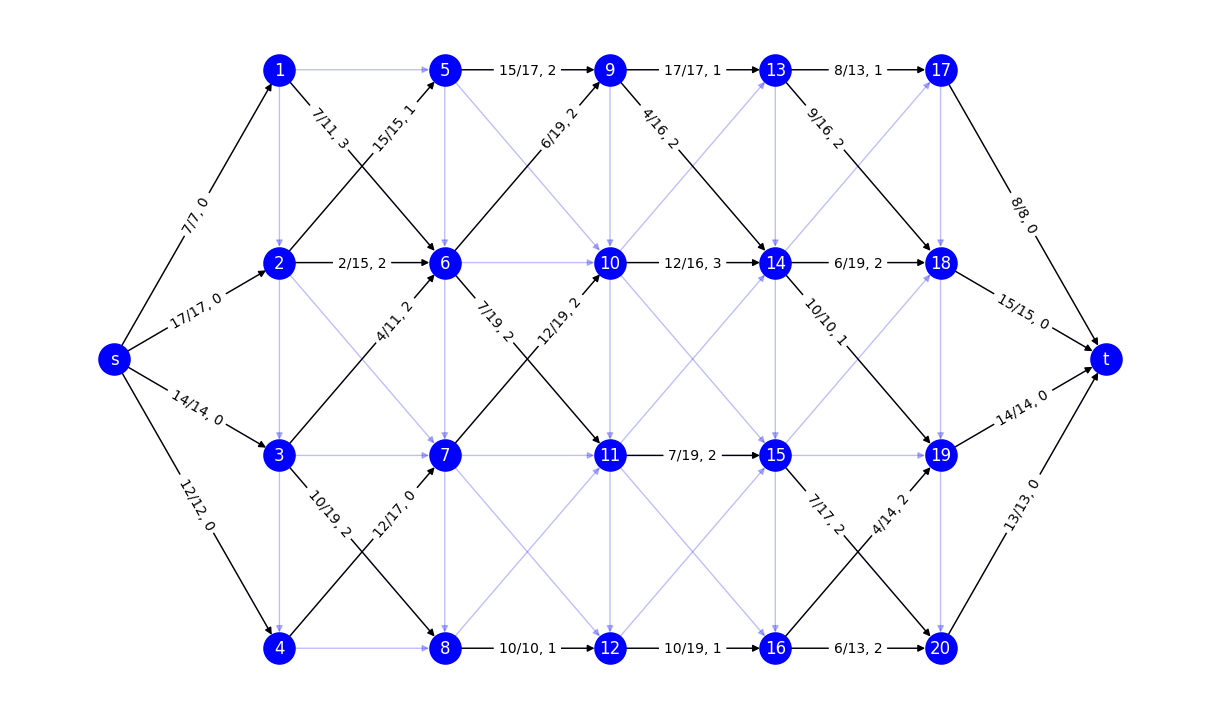

In [1041]:
mcf_ssp(network, 's', 't', num_car)
represent = nx.DiGraph()
for u, v, data in network.edges(data = True):
    if data['flow'] > 0:
        represent.add_edge(u,v,capacity = data['capacity'], cost = data['cost'], flow = data['flow'])

plt.figure(figsize = (12,7))
nx.draw(
    network, pos, edge_color='blue', width=1, linewidths=1,
    node_size=500, node_color='blue', alpha = 0.25,
)
nx.draw(
    represent, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='blue', font_color = 'white',
    labels={node: node for node in represent.nodes()},
)

edge_labels_center = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u == 's' or v == 't' or u + 1 == v or u + 4 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_center,
    label_pos = 0.5,
    font_color='black',
)
edge_labels_right = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u !=  's' and v != 't' and u + 3 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_right,
    label_pos = 0.3,
    font_color='black',
)
edge_labels_left = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u !=  's' and v != 't' and u + 5 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_left,
    label_pos = 0.7,
    font_color='black',
)
;

In [1042]:

np.random.seed(15)
mu = np.random.multinomial(100, [1/S]*S)  / 100
print(mu)


time_cost = [{(u,v): np.random.randint(5,10,size = M+1) for u,v in network.edges()} for _ in range(0,S)]
scenario_cost = [{(u,v) : mu[i] * time_cost[i][u,v] for u, v in network.edges()} for i in range(0,S)]
for i in range(0,S):
    for u,v in network.edges():
        for t in range(0,T):
            scenario_cost[i][u,v][t] += lagrange_multiplier[i][u,v][t]

scenario_cost = [{(u,v) : [round(scenario_cost[i][u,v][t]) for t in range(0,M+1)] for u, v in network.edges()} for i in range(0,S)]
scenario_capacities = [{(u,v): [capacities[u,v]] + np.random.randint(10,20, size = M).tolist() for u,v in network.edges()} for _ in range(0,S)]
scenario_flows = [{(u,v) : np.zeros(M+1).tolist() for u,v in network.edges()} for _ in range(0,S)]

for i in range(0,S):
    for node in sources:
        scenario_cost[i]['s', node] = np.zeros(M+1, dtype = int).tolist()
        scenario_capacities[i]['s',node] = [capacities['s',node]] * (M+1)
    for node in sinks:
        scenario_cost[i][node,'t'] = np.zeros(M+1).tolist()
        scenario_capacities[i][node,'t'] = [capacities[node,'t']] * (M+1)
for i in range(0,S):
    # time_capacities = {(u,v) : [capacities[u,v]] + np.random.randint(10,20, size = M).tolist() for u,v in network.edges()}
    # time_flows = {(u,v) : np.zeros(M+1) for u,v in network.edges()}

    nx.set_edge_attributes(network, scenario_cost[i], 'cost')
    nx.set_edge_attributes(network, scenario_capacities[i], 'capacity')
    nx.set_edge_attributes(network, scenario_flows[i], 'flow')
    td_mcf_ssp(network, 's', 't', M, 1, num_car)



[0.31 0.35 0.34]


In [ ]:
time_net = nx.DiGraph()
pos_time = {}
for i in range(0,10):
    for j in range(1,21):
        time_net.add_node(str(i) + str(j))
        pos_time[str(i) + str(j)] = (i, j)


# plt.figure(figsize = (27,27))
# nx.draw(
#     time_net, pos_time, edge_color='black', width=1, linewidths=1,
#     node_size=500, node_color='blue', font_color = 'white'
# )